## Import

In [1]:
import os
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
import umap

from pathlib import Path

from albumentations.pytorch import ToTensorV2
from catalyst.dl import SupervisedRunner, Runner
from catalyst.core import Callback, CallbackOrder, IRunner
from sklearn.model_selection import KFold
from tqdm import tqdm

## Settings

In [2]:
sns.set_context("talk")
plt.style.use("ggplot")

In [3]:
DATA_PATH = "/home/knikaido/work/atma10/data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
SUB_PATH = DATA_PATH + "atmacup10__sample_submission.csv"

In [4]:
SEED = 42
N_SPLITS = 5
SHUFFLE = True
EPOCH = 50
OUTPUT_DIR = './output/'

DATASET_CONFIG = {
    'loader': {
      'train': {
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 2,
        'shuffle': False,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}

config = DATASET_CONFIG
SAVE_TEST_SUB_PATH = "sub05.csv"

SUM = 400

## Utility

In [5]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(SEED)

In [6]:
palette = pd.read_csv(DATA_PATH + "palette.csv")
palette.head()

,ratio,color_r,color_g,color_b,object_id
0,0.013781,40,4,0,000405d9a5e3f49fc49d
1,0.040509,221,189,129,000405d9a5e3f49fc49d
2,0.036344,207,175,117,000405d9a5e3f49fc49d
3,0.033316,230,197,129,000405d9a5e3f49fc49d
4,0.039600,194,161,106,000405d9a5e3f49fc49d


In [7]:
# パーセント表示に直して四捨五入
palette["ratio_int"] = palette["ratio"].map(lambda x: int(np.round(400 * x)))

# `object_id`で集約してratio_intを足し合わせると100を超えたり100に満たない場合がある
palette.groupby("object_id")["ratio_int"].sum()

object_id
000405d9a5e3f49fc49d    400
001020bd00b149970f78    400
0011d6be41612ec9eae3    400
0012765f7a97ccc3e9e9    400
00133be3ff222c9b74b0    398
                       ... 
fff4bbb55fd7702d294e    401
fffbe07b997bec00e203    402
fffd1675758205748d7f    397
fffd43b134ba7197d890    401
ffff22ea12d7f99cff31    401
Name: ratio_int, Length: 23995, dtype: int64

In [8]:
# `object_id`で集約した時に足し合わせてちょうど100になるようにする
palette_group_dfs = []
for _, df in tqdm(palette.groupby("object_id"),
                  total=palette["object_id"].nunique()):
    # 足し合わせた和が100を超過する場合
    if df["ratio_int"].sum() > SUM:
        n_excess = df["ratio_int"].sum() - SUM
        # ちょっと雑だが一番比率が多い色の割合を減らすことで和を100に揃える
        max_ratio_int_idx = df["ratio_int"].idxmax()
        df.loc[max_ratio_int_idx, "ratio_int"] -= n_excess
    elif df["ratio_int"].sum() < SUM:
        n_lack = SUM - df["ratio_int"].sum()
        max_ratio_int_idx = df["ratio_int"].idxmax()
        df.loc[max_ratio_int_idx, "ratio_int"] += n_lack
    else:
        pass
    palette_group_dfs.append(df)

new_palette = pd.concat(palette_group_dfs, axis=0).reset_index(drop=True)

100%|██████████| 23995/23995 [00:10<00:00, 2351.67it/s]


In [9]:
# `object_id`で集約してratio_intを足し合わせるとちょうど100になる
new_palette.groupby("object_id")["ratio_int"].sum()

object_id
000405d9a5e3f49fc49d    400
001020bd00b149970f78    400
0011d6be41612ec9eae3    400
0012765f7a97ccc3e9e9    400
00133be3ff222c9b74b0    400
                       ... 
fff4bbb55fd7702d294e    400
fffbe07b997bec00e203    400
fffd1675758205748d7f    400
fffd43b134ba7197d890    400
ffff22ea12d7f99cff31    400
Name: ratio_int, Length: 23995, dtype: int64

In [10]:
def _create_random_image(sample: pd.DataFrame) -> np.ndarray:
    """
    配置はランダムで色の比率がsampleで指示された値になるようにした
    10x10の画像を生成する
    """
    # まず一次元で定義しておく
    image = np.zeros((400, 3), dtype=np.uint8)
    # sampleの頭から1行ずつその行の色をその行のratio_int分だけコピーして画像を埋める
    head = 0
    for i, row in sample.iterrows():
        # sampleの行に書かれた色
        patch = np.array([[row.color_r, row.color_g, row.color_b]], dtype=np.uint8)
        # sampleの行に書かれたratio_int分だけコピーする
        patch = np.tile(patch, row.ratio_int).reshape(row.ratio_int, -1)
        # 画像を上の手順で出した色で埋める
        image[head:head + row.ratio_int, :] = patch
        head += row.ratio_int
    # 乱数で順番をランダム化する
    indices = np.random.permutation(np.arange(400))
    image = image[indices, :].reshape(20, 20, 3)
    return image

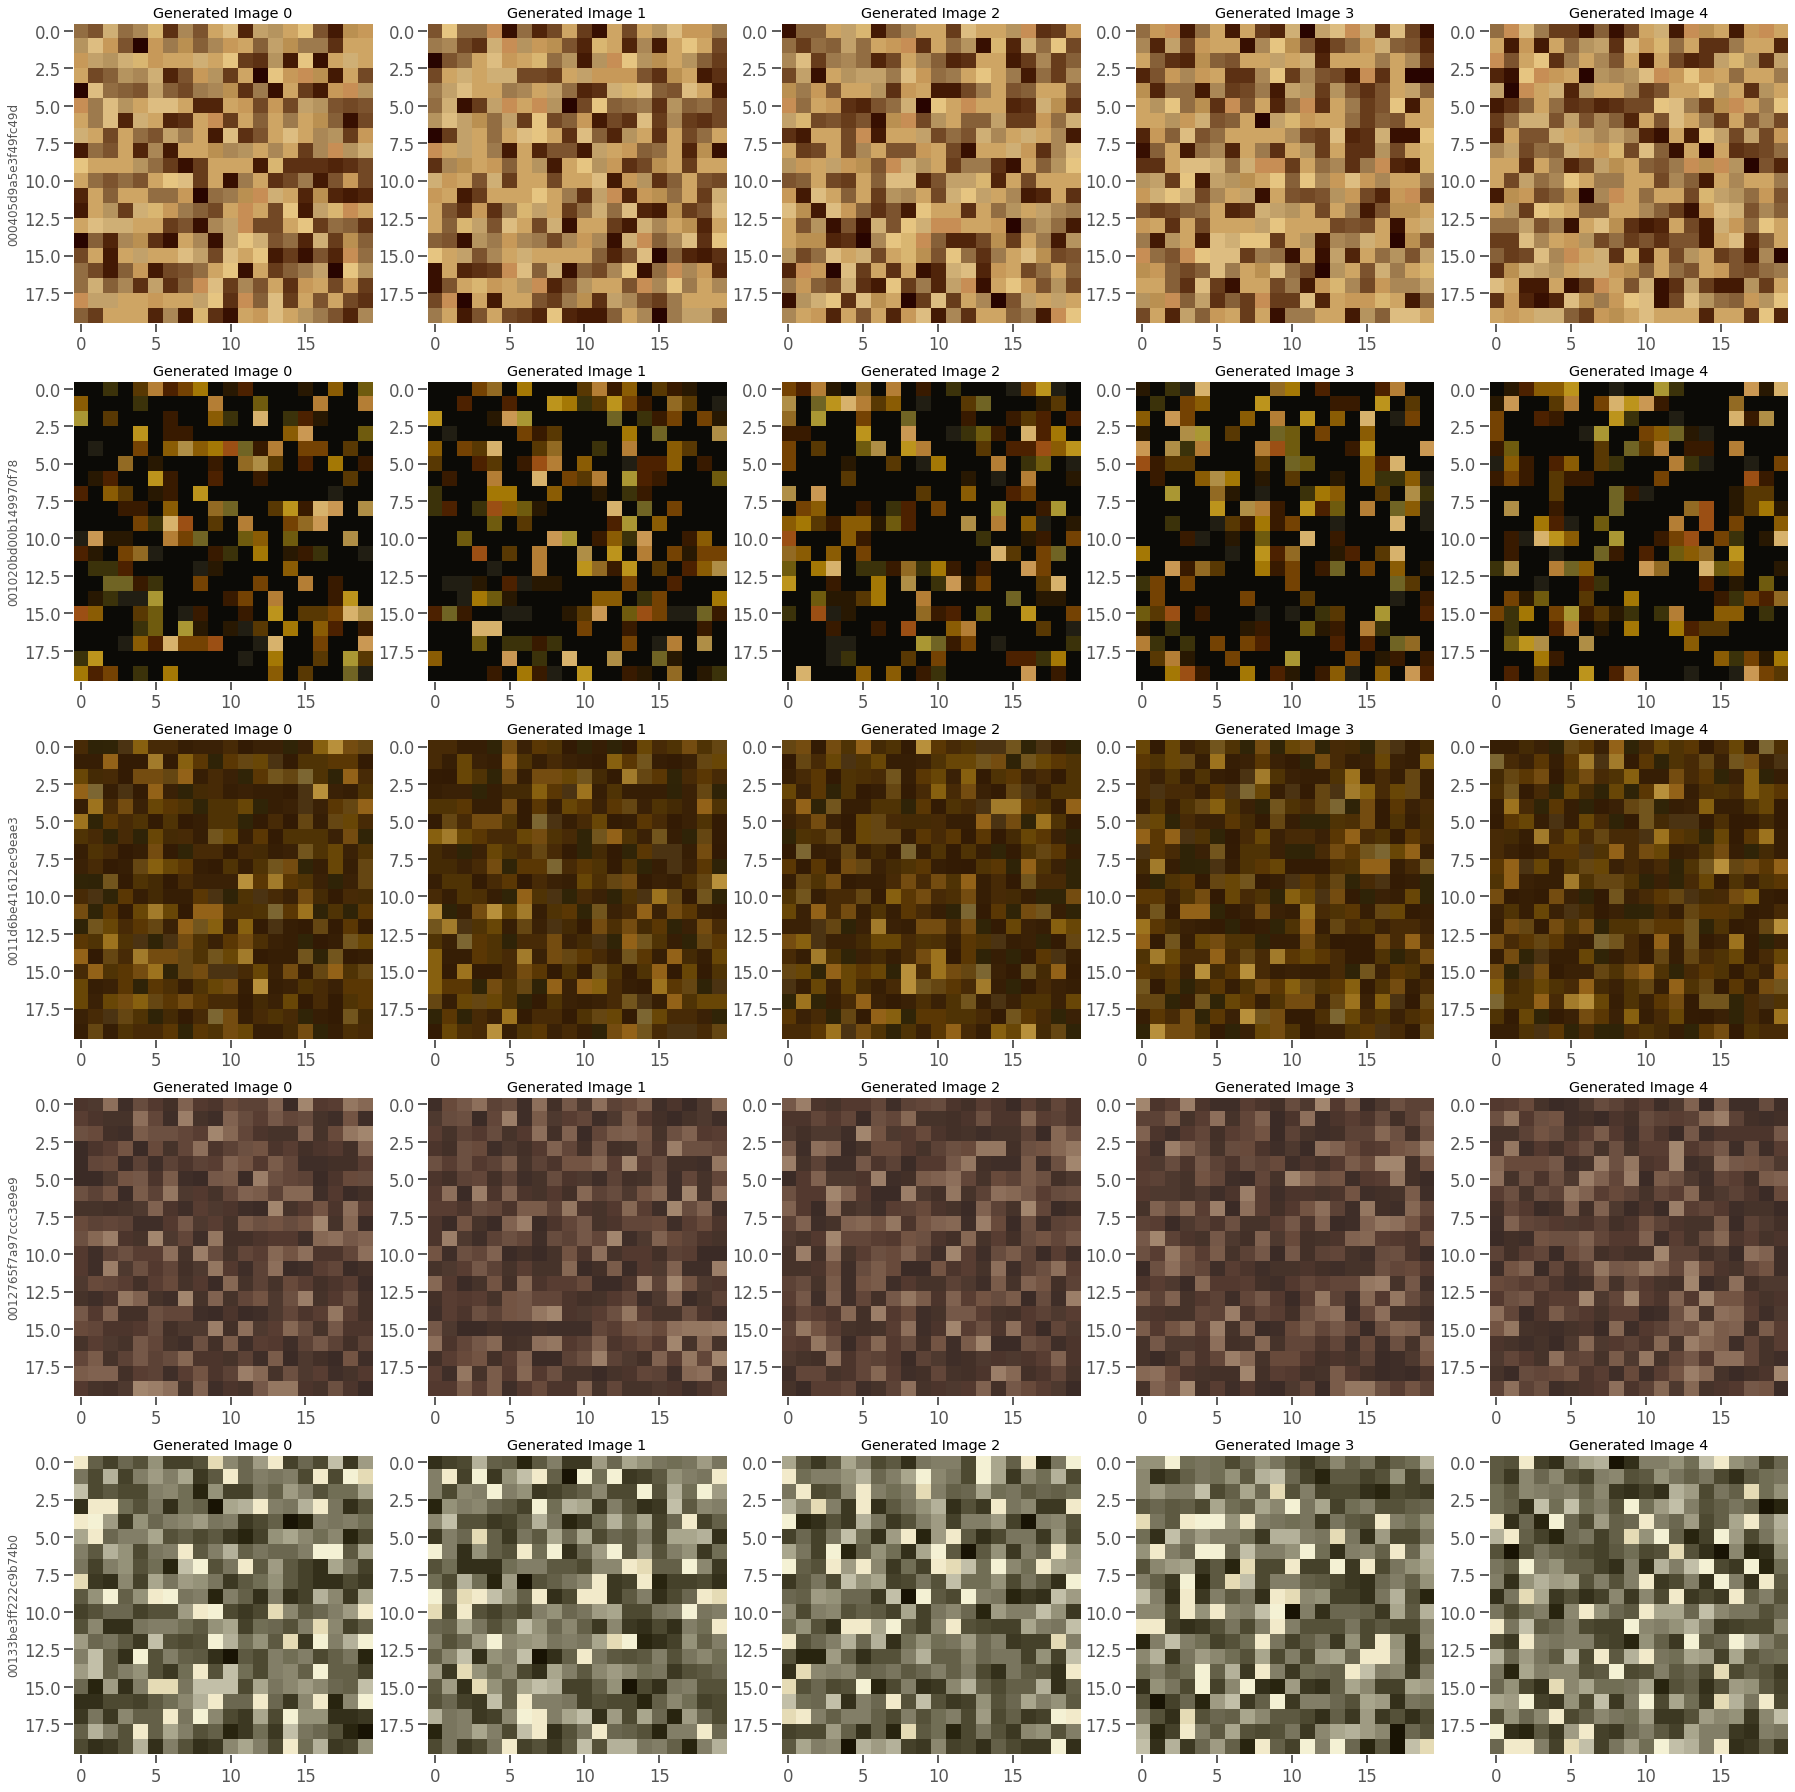

In [11]:
unique_object_ids = new_palette["object_id"].unique()
N_IMAGES_FOR_OBJ_ID = 5
N_OBJ_IDS = 5

fig, axes = plt.subplots(nrows=N_OBJ_IDS, ncols=N_IMAGES_FOR_OBJ_ID, figsize=(25, 25))
for i in range(N_OBJ_IDS):
    obj_id = unique_object_ids[i]
    palette_obj_id = new_palette.query(f"object_id == '{obj_id}'")
    axes[i, 0].set_ylabel(obj_id)
    for j in range(N_IMAGES_FOR_OBJ_ID):
        generated = _create_random_image(palette_obj_id)
        axes[i, j].imshow(generated)
        axes[i, j].grid(False)
        axes[i, j].set_title(f"Generated Image {j}")

plt.tight_layout()
plt.show()

In [12]:
class ColorImageDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, transforms=None):
        self.object_id = df["object_id"].unique()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.object_id)

    def __getitem__(self, idx: int):
        object_id = self.object_id[idx]
        sample = self.df.query(f"object_id == '{object_id}'")[
            ["ratio_int", "color_r", "color_g", "color_b"]]
        # 負例のサンプリングを行う
        while True:
            neg_sample_id = np.random.choice(self.object_id)
            if neg_sample_id != object_id:
                break
        neg_sample = self.df.query(f"object_id == '{neg_sample_id}'")[
            ["ratio_int", "color_r", "color_g", "color_b"]]

        # アンカー画像の生成
        anchor = _create_random_image(sample)
        # 正例の生成
        pos = _create_random_image(sample)
        # 負例の生成
        neg = _create_random_image(neg_sample)

        anchor = self.transforms(image=anchor)["image"]
        pos = self.transforms(image=pos)["image"]
        neg = self.transforms(image=neg)["image"]
        return anchor, pos, neg

In [13]:
def tensor_max(x, axis=None, keepdims=False):
    if axis is None:
        axis = range(x.ndim)
    elif isinstance(axis, int):
        axis = [axis]
    else:
        axis = sorted(axis)

    for ax in axis[::-1]:
        x = x.max(dim=ax, keepdim=keepdims)[0]

    return x

def tensor_min(x, axis=None, keepdims=False):
    if axis is None:
        axis = range(x.ndim)
    elif isinstance(axis, int):
        axis = [axis]
    else:
        axis = sorted(axis)

    for ax in axis[::-1]:
        x = x.min(dim=ax, keepdim=keepdims)[0]

    return x

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3)       
        )

    def forward(self, x):
        x = self.cnn_encoder(x)
        return x.mean(dim=[2, 3]) + tensor_max(x, axis=(2,3))

In [15]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cos = nn.CosineSimilarity()

    def forward(self, anchor, pos, neg):
        pos_loss = 1.0 - self.cos(anchor, pos).mean(dim=0)
        neg_loss = self.cos(anchor, neg).mean(dim=0)
        return pos_loss + neg_loss

In [16]:
class ContrastRunner(Runner):
    def predict_batch(self, batch, **kwargs):
        return super().predict_batch(batch, **kwargs)

    def _handle_batch(self, batch):
        anchor, pos, neg = batch[0], batch[1], batch[2]
        anchor = anchor.to(self.device)
        pos = pos.to(self.device)
        neg = neg.to(self.device)

        anchor_emb = self.model(anchor)
        pos_emb = self.model(pos)
        neg_emb = self.model(neg)

        loss = self.criterion(anchor_emb, pos_emb, neg_emb)
        self.batch_metrics.update({
            "loss": loss
        })

        self.input = batch
        if self.is_train_loader:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [17]:
class SchedulerCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Scheduler)

    def on_loader_end(self, state: IRunner):
        lr = state.scheduler.get_last_lr()
        state.epoch_metrics["lr"] = lr[0]
        if state.is_train_loader:
            state.scheduler.step()

In [18]:
OUTDIR = Path("./output/PaletteEmbedding")
OUTDIR.mkdir(exist_ok=True, parents=True)

In [19]:
# kf = KFold(n_splits=5, random_state=1213, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unique_obj_id = new_palette["object_id"].unique()
# for fold, (trn_idx, val_idx) in enumerate(kf.split(unique_obj_id)):
print("*" * 100)
# print(f"Fold: {fold}")

trn_obj_id = unique_obj_id
#     val_obj_id = unique_obj_id[val_idx]

trn_palette = new_palette[
    new_palette["object_id"].isin(trn_obj_id)
].reset_index(drop=True)
#     val_palette = new_palette[
#         new_palette["object_id"].isin(val_obj_id)
#     ].reset_index(drop=True)

transforms = A.Compose([A.Normalize(), ToTensorV2()])
trn_dataset = ColorImageDataset(trn_palette, transforms)
#     val_dataset = ColorImageDataset(val_palette, transforms)

trn_loader = torchdata.DataLoader(
    trn_dataset, batch_size=128, shuffle=True, num_workers=20)
#     val_loader = torchdata.DataLoader(
#         val_dataset, batch_size=256, shuffle=False, num_workers=20)

model = CNNModel().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
callbacks = [SchedulerCallback()]
runner = ContrastRunner(device=device)
runner.train(model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=scheduler,
             callbacks=callbacks,
             loaders={"train": trn_loader},
             num_epochs=30,
             logdir=OUTDIR,
             verbose=True)

****************************************************************************************************


/home/user/.local/lib/python3.6/site-packages/catalyst/experiments/experiment.py:221: UserWarning:

Attention, there is only one dataloader - train



1/30 * Epoch (train): 100% 188/188 [01:07<00:00,  2.79it/s, loss=0.099]     
[2021-03-12 00:16:04,335] 
1/30 * Epoch 1 (_base): lr=0.0010
1/30 * Epoch 1 (train): loss=0.0350
2/30 * Epoch (train): 100% 188/188 [01:07<00:00,  2.79it/s, loss=-2.978e-02]
[2021-03-12 00:17:11,725] 
2/30 * Epoch 2 (_base): lr=0.0010
2/30 * Epoch 2 (train): loss=0.0176
3/30 * Epoch (train): 100% 188/188 [01:07<00:00,  2.78it/s, loss=-9.026e-02]
[2021-03-12 00:18:19,278] 
3/30 * Epoch 3 (_base): lr=0.0009
3/30 * Epoch 3 (train): loss=0.0231
4/30 * Epoch (train): 100% 188/188 [01:08<00:00,  2.73it/s, loss=0.091]     
[2021-03-12 00:19:28,102] 
4/30 * Epoch 4 (_base): lr=0.0008
4/30 * Epoch 4 (train): loss=0.0156
5/30 * Epoch (train): 100% 188/188 [01:07<00:00,  2.77it/s, loss=0.025]     
[2021-03-12 00:20:35,929] 
5/30 * Epoch 5 (_base): lr=0.0007
5/30 * Epoch 5 (train): loss=0.0020
6/30 * Epoch (train): 100% 188/188 [01:09<00:00,  2.72it/s, loss=0.007]     
[2021-03-12 00:21:45,080] 
6/30 * Epoch 6 (_base): lr

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unique_obj_id = new_palette["object_id"].unique()
transforms = A.Compose([A.Normalize(), ToTensorV2()])

embeddings = []
object_ids = []
# for fold, (_, val_idx) in enumerate(kf.split(unique_obj_id)):
val_obj_id = unique_obj_id
val_palette = new_palette[
    new_palette["object_id"].isin(val_obj_id)
].reset_index(drop=True)
val_dataset = ColorImageDataset(val_palette, transforms)
object_ids.extend(val_dataset.object_id.tolist())

val_loader = torchdata.DataLoader(val_dataset, batch_size=12, shuffle=False, num_workers=20)
model = CNNModel()
ckpt = torch.load(OUTDIR / f"checkpoints/best.pth")
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()
# アンカー画像にのみ推論
for anchor, _, _ in tqdm(val_loader):
    anchor = anchor.to(device)
    with torch.no_grad():
        embedding = model(anchor).detach().cpu().numpy()
    embeddings.append(embedding)

100%|██████████| 2000/2000 [01:06<00:00, 30.22it/s]


In [21]:
all_embeddings = np.concatenate(embeddings, axis=0)
len(all_embeddings), len(object_ids)

(23995, 23995)

In [22]:
embedding_df = pd.DataFrame(all_embeddings, 
                            columns=[f"color_embedding_{i}" for i in range(len(all_embeddings[0]))],
                            index=object_ids)
embedding_df.head()

,color_embedding_0,color_embedding_1,color_embedding_2,color_embedding_3,color_embedding_4,color_embedding_5,color_embedding_6,color_embedding_7,color_embedding_8,color_embedding_9,...,color_embedding_118,color_embedding_119,color_embedding_120,color_embedding_121,color_embedding_122,color_embedding_123,color_embedding_124,color_embedding_125,color_embedding_126,color_embedding_127
000405d9a5e3f49fc49d,-0.036169,2.205453,1.663827,1.046350,-0.153227,-0.094444,2.013547,0.015589,0.023521,-0.027219,...,3.489182,0.002314,-0.034105,-0.113414,-0.079132,-0.107150,1.736830,1.884821,-0.037344,3.027315
001020bd00b149970f78,-29.764025,4.321921,3.403480,1.820323,-14.792992,-23.646074,3.597474,-42.453773,-4.985262,-23.326777,...,6.431312,-16.015282,-35.568306,-31.451313,-28.230192,-20.683018,3.305398,4.370604,-12.854546,6.335687
0011d6be41612ec9eae3,-28.212364,3.651664,2.998196,1.534351,-14.058604,-22.348988,3.030409,-40.306946,-4.870861,-22.048981,...,5.381995,-15.138853,-33.830093,-29.773415,-26.770353,-19.525780,2.745749,3.836122,-12.179588,5.417415
0012765f7a97ccc3e9e9,-15.358156,2.420288,1.974572,1.129547,-7.658097,-12.148148,2.061192,-21.926128,-2.688633,-12.029198,...,3.732906,-8.211090,-18.359909,-16.258183,-14.586916,-10.707162,1.866953,2.585819,-6.641441,3.607471
00133be3ff222c9b74b0,2.563824,1.152804,0.791777,0.522045,1.312315,1.976370,0.928307,3.748610,0.552699,1.985762,...,1.755674,1.348163,3.238231,2.740560,2.413592,1.749107,0.795375,0.981547,1.061555,1.463791


In [23]:
embedding_df.values

array([[ -0.03616923,   2.2054532 ,   1.6638267 , ...,   1.8848214 ,
         -0.03734404,   3.0273154 ],
       [-29.764025  ,   4.3219213 ,   3.4034798 , ...,   4.3706036 ,
        -12.854546  ,   6.3356867 ],
       [-28.212364  ,   3.6516635 ,   2.9981961 , ...,   3.8361216 ,
        -12.179588  ,   5.417415  ],
       ...,
       [ -2.372543  ,   2.2529833 ,   1.7301438 , ...,   1.9870981 ,
         -1.069684  ,   3.0803282 ],
       [  5.781104  ,  -3.982276  ,  -3.0080235 , ...,  -3.472861  ,
          2.5458398 ,  -5.265484  ],
       [  1.3612776 ,   1.0332794 ,   0.65291005, ...,   0.7441334 ,
          0.58326197,   1.2287859 ]], dtype=float32)

In [24]:
reducer = umap.UMAP(random_state=42)
reduced = reducer.fit_transform(embedding_df.values)
umap_df = pd.DataFrame(reduced, columns=["dim0", "dim1"], index=embedding_df.index)
umap_df.head()

,dim0,dim1
000405d9a5e3f49fc49d,8.190331,-2.963508
001020bd00b149970f78,0.199140,11.479358
0011d6be41612ec9eae3,0.393768,9.813558
0012765f7a97ccc3e9e9,2.817229,1.529369
00133be3ff222c9b74b0,15.037532,-0.135921


In [25]:
train = pd.read_csv(DATA_PATH + "train.csv")
train["likes"] = np.log1p(train["likes"])
likes_df = train[["object_id", "likes"]]
likes_df.head()

,object_id,likes
0,0011d6be41612ec9eae3,3.891820
1,0012765f7a97ccc3e9e9,1.098612
2,0017be8caa87206532cb,1.791759
3,00181d86ff1a7b95864e,4.615121
4,001c52ae28ec106d9cd5,2.079442


In [26]:
likes_df = likes_df.merge(umap_df, left_on="object_id", right_index=True, how="left")
likes_df

,object_id,likes,dim0,dim1
0,0011d6be41612ec9eae3,3.891820,0.393768,9.813558
1,0012765f7a97ccc3e9e9,1.098612,2.817229,1.529369
2,0017be8caa87206532cb,1.791759,NaN,NaN
3,00181d86ff1a7b95864e,4.615121,6.055354,-8.357012
4,001c52ae28ec106d9cd5,2.079442,-2.453974,9.000953
...,...,...,...,...
12021,ffedf8af4fd5b3873164,1.609438,6.744380,11.502425
12022,ffee34705ea44e1a0f79,0.000000,7.995249,13.712093
12023,ffefbe1faf771aa4f790,0.000000,11.618268,5.536328
12024,fff08e76cbb969eaddc7,2.708050,11.376652,7.377180


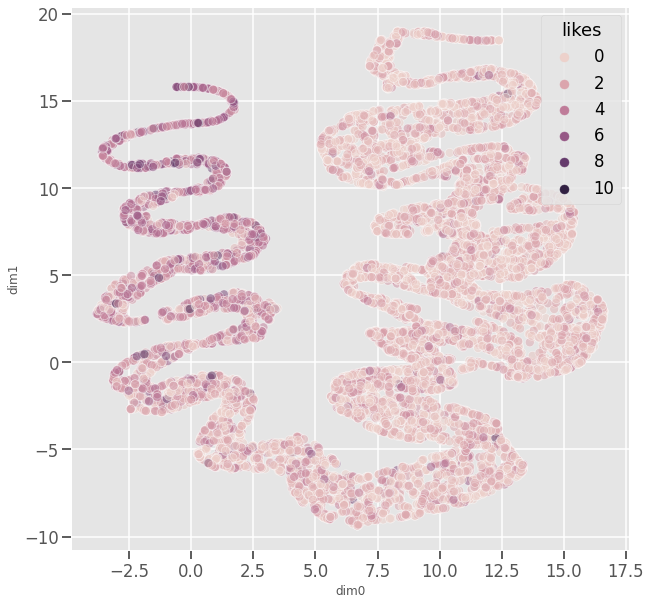

In [27]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="dim0", y="dim1", hue="likes", data=likes_df, alpha=0.5);

In [28]:
embedding_df_output = embedding_df.reset_index()
embedding_df_output = embedding_df_output.rename(columns={"index":"object_id"})
embedding_df_output

,object_id,color_embedding_0,color_embedding_1,color_embedding_2,color_embedding_3,color_embedding_4,color_embedding_5,color_embedding_6,color_embedding_7,color_embedding_8,...,color_embedding_118,color_embedding_119,color_embedding_120,color_embedding_121,color_embedding_122,color_embedding_123,color_embedding_124,color_embedding_125,color_embedding_126,color_embedding_127
0,000405d9a5e3f49fc49d,-0.036169,2.205453,1.663827,1.046350,-0.153227,-0.094444,2.013547,0.015589,0.023521,...,3.489182,0.002314,-0.034105,-0.113414,-0.079132,-0.107150,1.736830,1.884821,-0.037344,3.027315
1,001020bd00b149970f78,-29.764025,4.321921,3.403480,1.820323,-14.792992,-23.646074,3.597474,-42.453773,-4.985262,...,6.431312,-16.015282,-35.568306,-31.451313,-28.230192,-20.683018,3.305398,4.370604,-12.854546,6.335687
2,0011d6be41612ec9eae3,-28.212364,3.651664,2.998196,1.534351,-14.058604,-22.348988,3.030409,-40.306946,-4.870861,...,5.381995,-15.138853,-33.830093,-29.773415,-26.770353,-19.525780,2.745749,3.836122,-12.179588,5.417415
3,0012765f7a97ccc3e9e9,-15.358156,2.420288,1.974572,1.129547,-7.658097,-12.148148,2.061192,-21.926128,-2.688633,...,3.732906,-8.211090,-18.359909,-16.258183,-14.586916,-10.707162,1.866953,2.585819,-6.641441,3.607471
4,00133be3ff222c9b74b0,2.563824,1.152804,0.791777,0.522045,1.312315,1.976370,0.928307,3.748610,0.552699,...,1.755674,1.348163,3.238231,2.740560,2.413592,1.749107,0.795375,0.981547,1.061555,1.463791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23990,fff4bbb55fd7702d294e,6.160010,-6.878108,-5.061858,-3.205782,3.521006,5.102498,-5.831976,9.107737,1.017232,...,-10.253693,3.271213,7.498731,6.701607,6.005741,4.534032,-5.066477,-5.990018,2.760120,-9.125712
23991,fffbe07b997bec00e203,4.721174,-14.087090,-9.517551,-5.864160,2.924784,4.001556,-11.748345,6.899107,0.579224,...,-21.486847,2.666819,5.819915,5.485773,4.948926,3.694578,-9.928772,-11.966454,2.467824,-18.342102
23992,fffd1675758205748d7f,-2.372543,2.252983,1.730144,1.173889,-1.495362,-1.910995,1.988556,-3.212807,-0.442202,...,3.531689,-1.326123,-2.750962,-2.505891,-2.200976,-1.800378,1.729329,1.987098,-1.069684,3.080328
23993,fffd43b134ba7197d890,5.781104,-3.982276,-3.008024,-1.883911,3.189708,4.822171,-3.368989,8.423428,0.958321,...,-5.974770,3.073999,7.024139,6.267106,5.656250,4.197815,-2.874875,-3.472861,2.545840,-5.265484


In [29]:
embedding_df_output.to_csv(DATA_PATH + 'color_emb200_max128.csv', index=False)